In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/Year 4/Artificial Intelligence/')

In [ ]:
!ls

'Image Classification Models.ipynb'			  'MobileNet_V2 Classification.ipynb'   ref
'Image Classification on Oxford-IIIT Pets dataset.ipynb'   models


In [ ]:
# Import neccessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from keras import callbacks
from keras import layers, models
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

In [ ]:
(train_raw, val_raw, test_raw), ds_info = tfds.load(name='oxford_iiit_pet',
                                                    split=['train[:80%]',
                                                          'train[80%:]',
                                                          'test'],
                                                    shuffle_files=True,
                                                    as_supervised=True, # Returns (image, label)
                                                    with_info=True # To retrieve dataset info and label names
                                                    )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteEP5X3A/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteEP5X3A/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [ ]:
IMG_SIZE = 224

# Resize images
def resize(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

train_ds = train_raw.map(resize)
val_ds = val_raw.map(resize)
test_ds = test_raw.map(resize)

In [ ]:
# Encoding the target label
def one_hot_encode(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

In [ ]:
num_classes = 37

train_ds = train_ds.map(one_hot_encode)
val_ds = val_ds.map(one_hot_encode)
test_ds = test_ds.map(one_hot_encode)

In [ ]:
data_augmentation = keras.Sequential(
    [layers.RandomFlip('horizontal'),
     layers.RandomRotation(factor=(-0.025, 0.025)),
     layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
     layers.RandomContrast(factor=0.1),
     ])

In [ ]:
BATCH_SIZE = 32

In [ ]:
train_ds = train_ds.cache().shuffle(1000).batch(batch_size=BATCH_SIZE,
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.cache().shuffle(1000).batch(batch_size=BATCH_SIZE,
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

test_ds = test_ds.cache().shuffle(1000).batch(batch_size=BATCH_SIZE,
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
IMG_SIZE = 224

base_model = keras.applications.MobileNetV2(input_shape=(IMG_SIZE, IMG_SIZE, 3),
                                            include_top=False, weights="imagenet")

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
# Freeze the base_model
base_model.trainable = False

In [ ]:
# Create new model on top
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)

In [ ]:
x = keras.applications.mobilenet_v2.preprocess_input(x)

In [ ]:
x = base_model(x, training=False)

In [ ]:
x.shape

TensorShape([None, 7, 7, 1280])

In [ ]:
# Rebuild top layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Regularize with dropout

outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambd  (None, 224, 224, 3)       0         
 a)                                                              
                                                                 
 tf.math.subtract (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                             

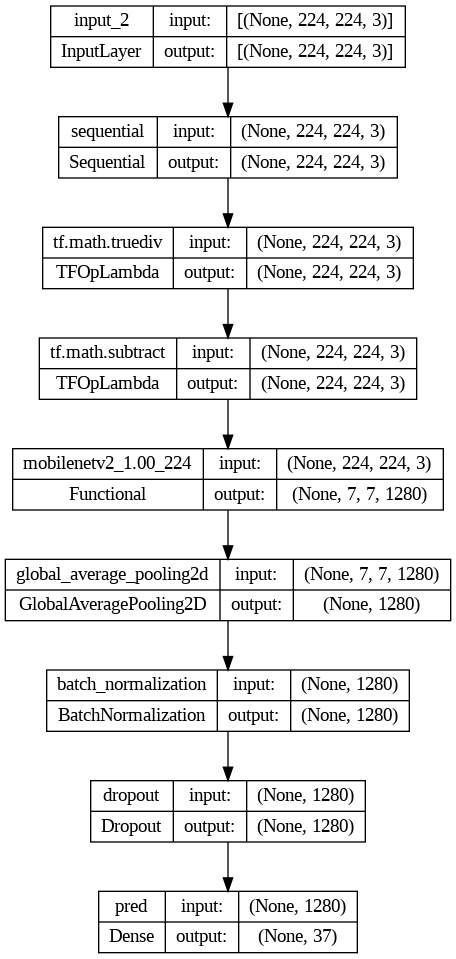

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.CategoricalCrossentropy(),
              metrics=[keras.metrics.CategoricalAccuracy()]
             )

In [ ]:
earlystopping = callbacks.EarlyStopping(monitor='val_loss',
                                        mode='min',
                                        patience=5,
                                        restore_best_weights=True)

In [ ]:
EPOCHS = 20

history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1,
                    callbacks =[earlystopping])

Epoch 1/20
92/92 [==============================] - 208s 2s/step - loss: 1.3949 - categorical_accuracy: 0.6056 - val_loss: 0.6107 - val_categorical_accuracy: 0.8587
Epoch 2/20
92/92 [==============================] - 181s 2s/step - loss: 0.4025 - categorical_accuracy: 0.8702 - val_loss: 0.4174 - val_categorical_accuracy: 0.8804
Epoch 3/20
92/92 [==============================] - 191s 2s/step - loss: 0.2966 - categorical_accuracy: 0.9025 - val_loss: 0.3810 - val_categorical_accuracy: 0.8818
Epoch 4/20
92/92 [==============================] - 183s 2s/step - loss: 0.2283 - categorical_accuracy: 0.9249 - val_loss: 0.3616 - val_categorical_accuracy: 0.8954
Epoch 5/20
92/92 [==============================] - 185s 2s/step - loss: 0.1789 - categorical_accuracy: 0.9399 - val_loss: 0.3741 - val_categorical_accuracy: 0.8954
Epoch 6/20
92/92 [==============================] - 182s 2s/step - loss: 0.1422 - categorical_accuracy: 0.9528 - val_loss: 0.3733 - val_categorical_accuracy: 0.9008
Epoch 7/20

In [ ]:
model.save('models/MobileNet_V2.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
# Assuming 'model' is your trained model and 'test_ds' is your test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 2s 2s/step


In [ ]:
y_pred

array([27, 36, 11, ..., 24, 28, 22])

Classification Report:
                             precision    recall  f1-score   support

                Abyssinian       0.84      0.88      0.86        98
          american_bulldog       0.59      0.90      0.71       100
 american_pit_bull_terrier       0.84      0.38      0.52       100
              basset_hound       0.99      0.88      0.93       100
                    beagle       0.88      0.96      0.92       100
                    Bengal       0.75      0.80      0.77       100
                    Birman       0.70      0.79      0.74        98
                    Bombay       0.93      0.88      0.90        88
                     boxer       0.84      0.82      0.83        98
         British_Shorthair       0.73      0.81      0.77        99
                 chihuahua       0.95      0.82      0.88       100
              Egyptian_Mau       0.91      0.72      0.80        96
    english_cocker_spaniel       0.97      0.91      0.94       100
            english_set

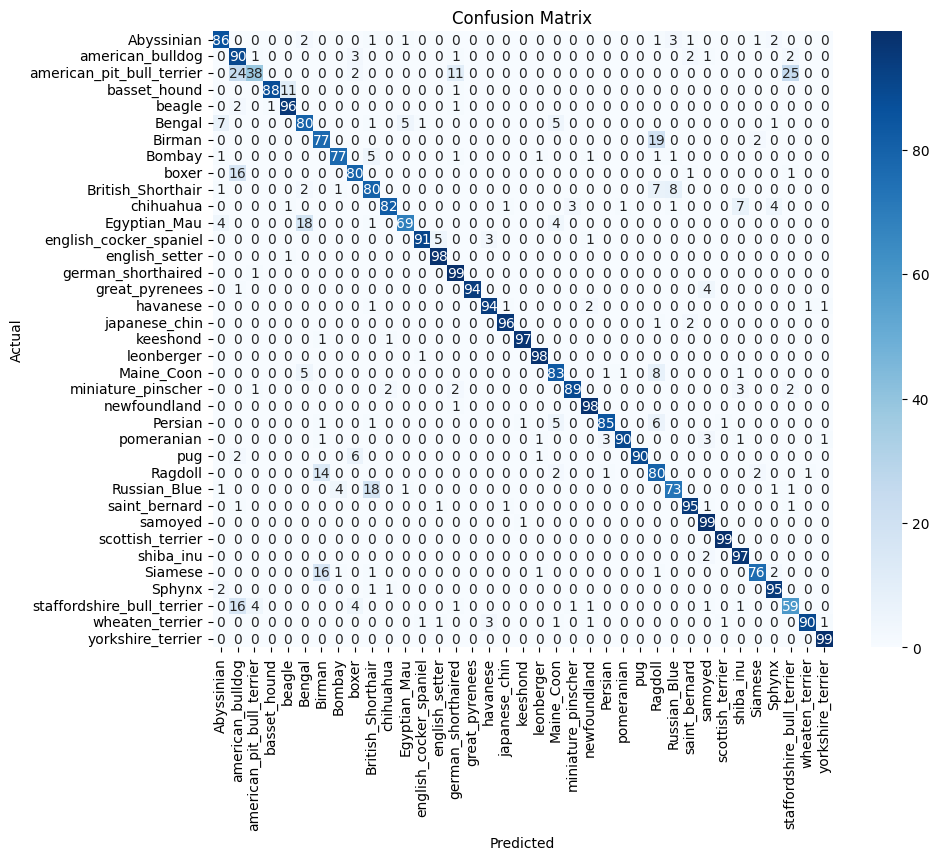

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the classification report
class_names = ds_info.features['label'].names  # Ensure this list is available or manually define it
class_report = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report:\n', class_report)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, f1_score

# Assuming y_true are the true labels/values and y_pred are the predicted labels/values
accuracy = accuracy_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)  # squared=False returns RMSE

print("Accuracy:", accuracy)
print("MAE:", mae)
print("RMSE:", rmse)

Accuracy: 0.8791118421052632
MAE: 1.722861842105263
RMSE: 6.074126354045681


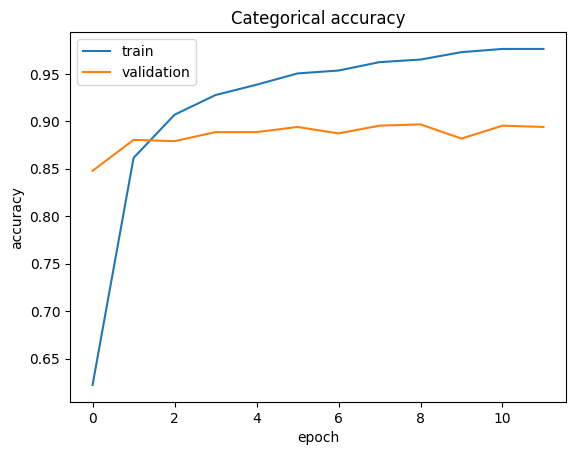

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

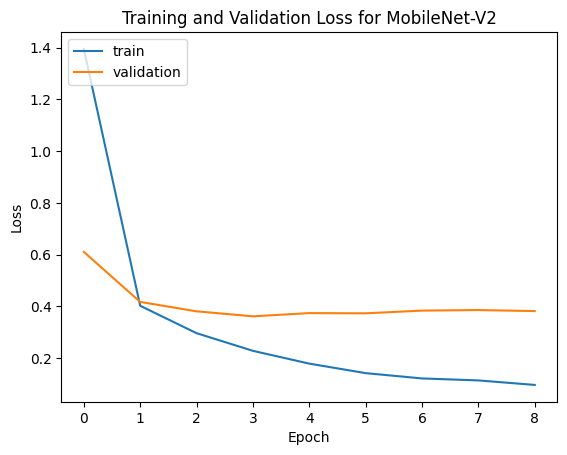

In [ ]:
def plot_loss(hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('Training and Validation Loss for MobileNet-V2')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_loss(history)

### Test on new instances

In [ ]:
from keras.preprocessing import image


# Load the saved model
loaded_model = keras.models.load_model('models/ResNet50_V2.h5')

# Function to preprocess the uploaded image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Expand dimensions to match model input shape
    return img_array

# Function to make predictions
def predict_image(img_array):
    predictions = loaded_model.predict(img_array)
    predicted_class = np.argmax(predictions[0])  # Get the index of the class with highest probability
    return predicted_class

In [ ]:
uploaded_file_path = "test-data/sammoyed-test.jpg"

# Preprocess the uploaded image
preprocessed_img = preprocess_image(uploaded_file_path)

class_names = ds_info.features['label'].names

# Make predictions
predicted_class = predict_image(preprocessed_img)

# Display the prediction
print("Predicted class index:", predicted_class)

# Function to map class index to class name
def get_class_name(class_index):
    return class_names[class_index]

# Example usage:
predicted_class_name = get_class_name(predicted_class)

# Print the actual name of the predicted class
print("Predicted class:", predicted_class_name)

1/1 [==============================] - 3s 3s/step
Predicted class index: 29
Predicted class: samoyed


In [ ]:
!pip install visualkeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.8/993.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
import visualkeras


visualkeras.layered_view(loaded_model).show() # display using your system viewer

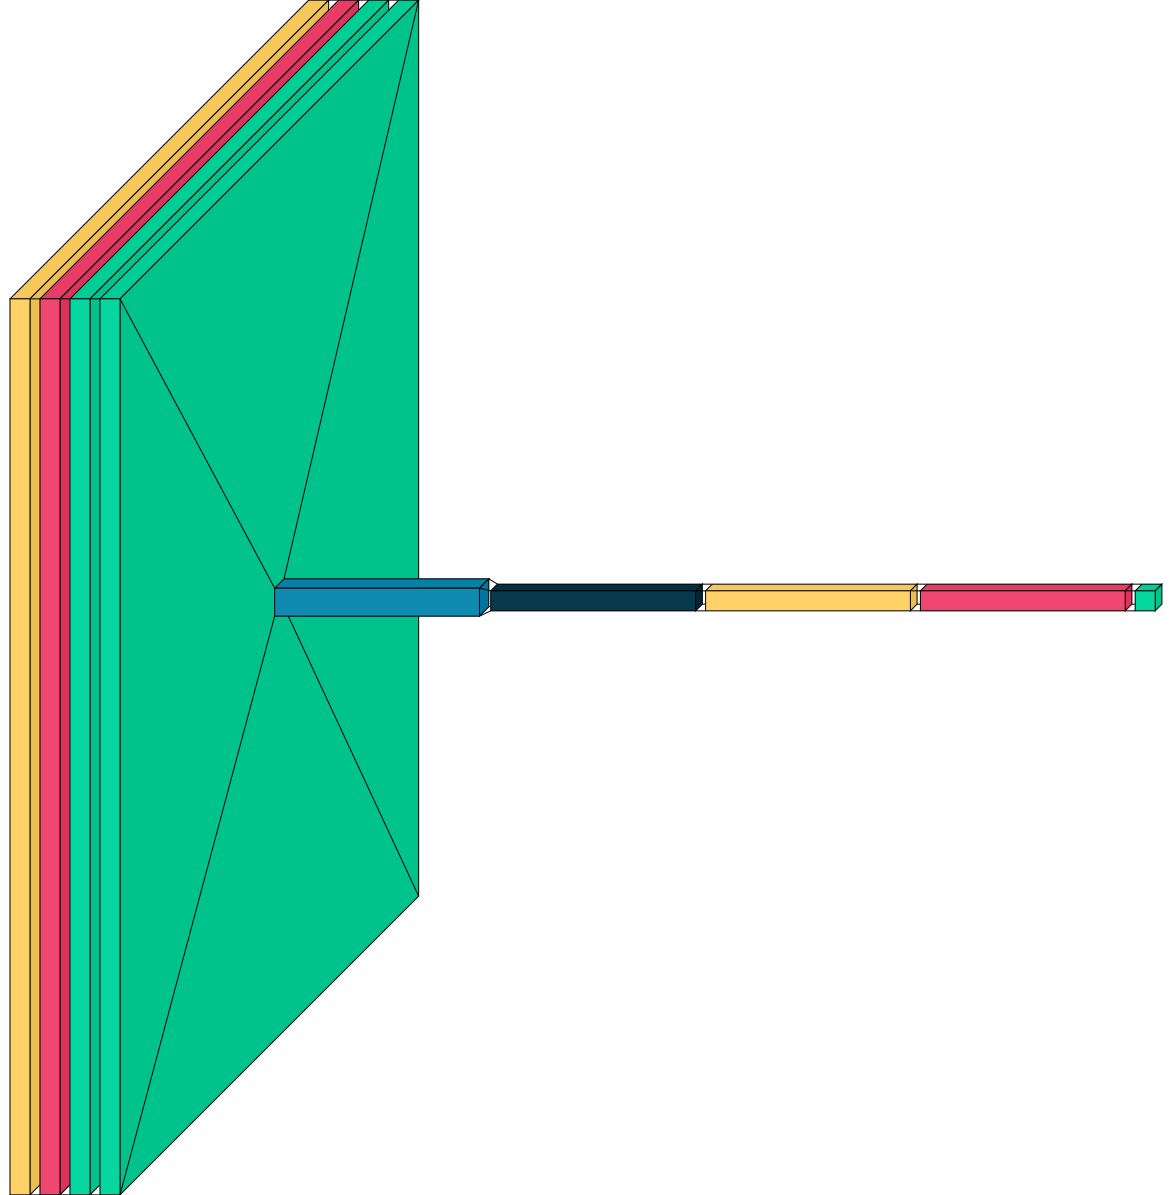

In [ ]:
visualkeras.layered_view(loaded_model)

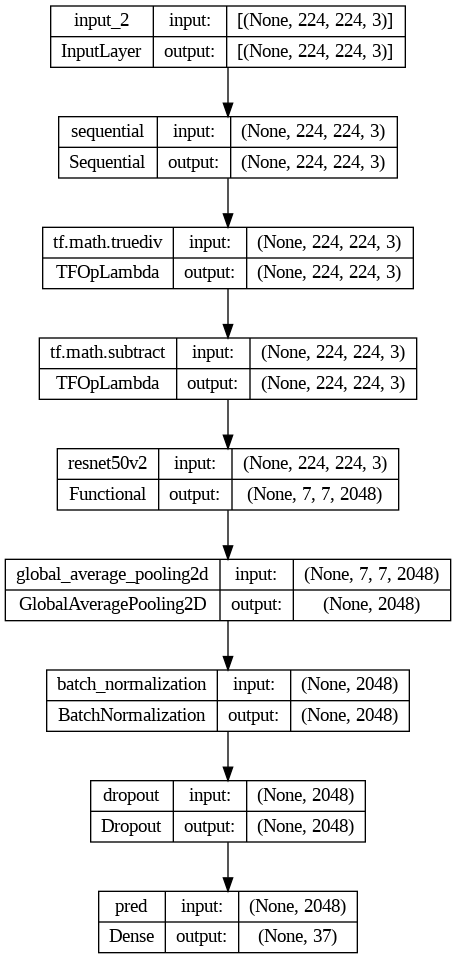

In [ ]:
keras.utils.plot_model(loaded_model, show_shapes=True)

In [ ]:
# Assuming 'model' is your trained model and 'test_ds' is your test dataset
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = loaded_model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

1/1 [==============================] - 6s 6s/step


Classification Report:
                             precision    recall  f1-score   support

                Abyssinian       0.75      0.84      0.79        98
          american_bulldog       0.70      0.81      0.75        99
 american_pit_bull_terrier       0.75      0.44      0.55       100
              basset_hound       0.92      0.93      0.93       100
                    beagle       0.89      0.87      0.88        98
                    Bengal       0.82      0.78      0.80        99
                    Birman       0.70      0.77      0.73        99
                    Bombay       0.95      0.87      0.91        87
                     boxer       0.87      0.86      0.86        99
         British_Shorthair       0.85      0.73      0.79        98
                 chihuahua       0.85      0.84      0.84        99
              Egyptian_Mau       0.82      0.87      0.84        97
    english_cocker_spaniel       0.91      0.92      0.92       100
            english_set

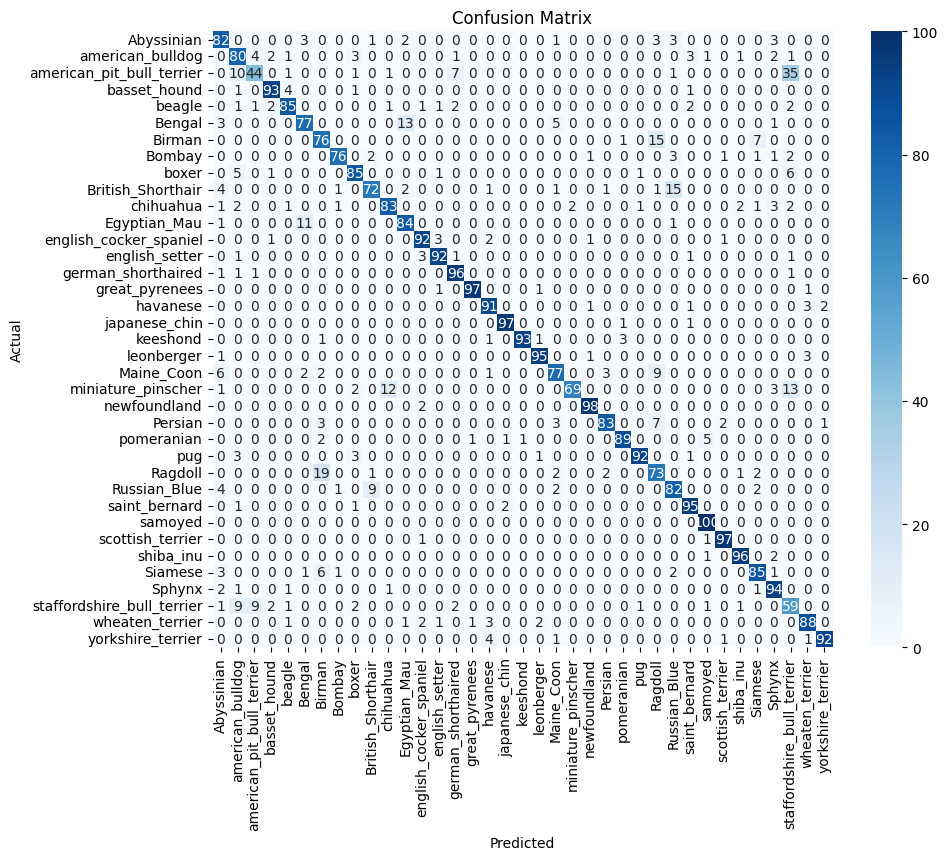

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Print the classification report
class_names = ds_info.features['label'].names  # Ensure this list is available or manually define it
class_report = classification_report(y_true, y_pred, target_names=class_names)
print('Classification Report:\n', class_report)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, f1_score

# Assuming y_true are the true labels/values and y_pred are the predicted labels/values
accuracy = accuracy_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred, squared=False)  # squared=False returns RMSE

print("Accuracy:", accuracy)
print("MAE:", mae)
print("RMSE:", rmse)

Accuracy: 0.865953947368421
MAE: 2.1211622807017543
RMSE: 6.883905715125451
